In [ ]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn plotly joblib gradio xgboost shap

# ---------------------------
# Imports & Constants
# ---------------------------
import os, math, joblib, warnings
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import gradio as gr

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Paths to save artifacts
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "wastage_best_model.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, "wastage_scaler.joblib")
ENCODERS_PATH = os.path.join(MODEL_DIR, "wastage_label_encoders.joblib")

# NGO database (simple)
NGOS = {
    "Urban": ["NGO FoodBank Delhi", "Robin Hood Army", "CityMeals"],
    "Suburban": ["Akshaya Patra", "Feeding India"],
    "Rural": ["Gram Seva Trust", "Village Relief NGO"]
}

In [ ]:
# ---------------------------
# 1) Synthetic Dataset Creator (if real CSV unavailable)
# ---------------------------
def make_synthetic(n=1000, outpath="synthetic_food_wastage.csv", seed=42):
    np.random.seed(seed)
    types = ["Vegetables","Meat","Dairy","Grains","Sweets"]
    events = ["Corporate","Birthday","Wedding","Religious","Casual"]
    store = ["Refrigerated","Room Temperature"]
    purchase = ["Regular","LastMinute"]
    season = ["Summer","Winter","Monsoon","All Seasons"]
    prep = ["Buffet","Plated","Finger Food"]
    locs = ["Urban","Suburban","Rural"]
    pricing = ["Low","Moderate","High"]

    rows=[]
    start = datetime.today() - timedelta(days=n)
    for i in range(n):
        guests = int(np.clip(np.random.poisson(50), 5, 600))
        qty = int(np.clip(guests*(0.2 + np.random.rand()*0.9), 5, 2000))
        # Base waste depends on event type and storage randomness
        event_effect = np.random.choice([0.9,1.0,1.1,1.3,0.8])
        storage_penalty = 1.2 if np.random.rand() < 0.15 else 1.0
        seasonal_factor = 1.1 if np.random.choice(["Summer","Monsoon"]) else 1.0
        base_waste = int(max(0, qty * (0.05 + np.random.rand()*0.25) * event_effect * storage_penalty * seasonal_factor))
        row = {
            "Date": (start + timedelta(days=i)).strftime("%Y-%m-%d"),
            "Type of Food": np.random.choice(types),
            "Number of Guests": guests,
            "Event Type": np.random.choice(events),
            "Quantity of Food": qty,
            "Storage Conditions": np.random.choice(store),
            "Purchase History": np.random.choice(purchase),
            "Seasonality": np.random.choice(season),
            "Preparation Method": np.random.choice(prep),
            "Geographical Location": np.random.choice(locs),
            "Pricing": np.random.choice(pricing),
            "Wastage Food Amount": base_waste
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(outpath, index=False)
    print(" Synthetic dataset saved:", outpath)
    return df

In [ ]:
# ---------------------------
# 2) Load / Inspect
# ---------------------------
def load_and_inspect(csv_path):
    df = pd.read_csv(csv_path)
    print("Shape:", df.shape)
    display(df.head())
    print("\nColumns and dtypes:\n", df.dtypes)
    return df

# If no dataset provided - create synthetic
CSV_PATH = "/content/drive/MyDrive/personalized_recs_dataset.csv"
if not os.path.exists(CSV_PATH):
    df = make_synthetic(n=1200, outpath=CSV_PATH)
else:
    df = load_and_inspect(CSV_PATH)


Shape: (140320, 3)


,student_id,course_id,rating
0,861,2-speed-it,1
1,3773,2-speed-it,5
2,3093,2-speed-it,5
3,467,2-speed-it,5
4,4427,2-speed-it,5



Columns and dtypes:
 student_id     int64
course_id     object
rating         int64
dtype: object


### Basic stats


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
student_id,140320.0,NaN,NaN,NaN,2501.851283,1444.11918,1.0,1253.0,2506.0,3750.25,5000.0
course_id,140320,1835,machine-learning,8570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,140320.0,NaN,NaN,NaN,4.619185,0.821347,1.0,5.0,5.0,5.0,5.0


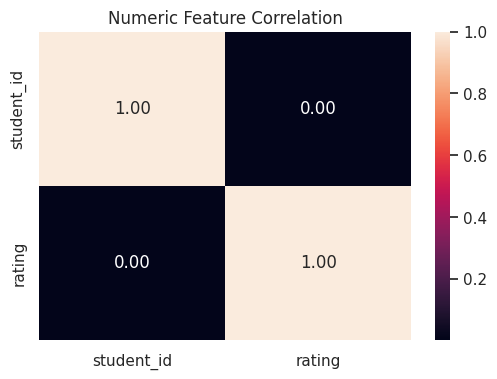

In [ ]:
# ---------------------------
# 3) EDA (plots + brief textual insights)
# ---------------------------
def do_eda(df):
    print("### Basic stats")
    display(df.describe(include='all').T)

    # Check if 'Wastage Food Amount' column exists
    if "Wastage Food Amount" in df.columns:
        # Distribution
        plt.figure(figsize=(8,4))
        sns.histplot(df["Wastage Food Amount"], kde=True)
        plt.title("Distribution of Wastage Food Amount")
        plt.xlabel("Wastage (kg)")
        plt.show()

        # Wastage vs Event Type (boxplot)
        if "Event Type" in df.columns:
            plt.figure(figsize=(10,5))
            order = df.groupby("Event Type")["Wastage Food Amount"].median().sort_values(ascending=False).index
            sns.boxplot(x="Event Type", y="Wastage Food Amount", data=df, order=order)
            plt.title("Wastage by Event Type (Boxplot)")
            plt.show()
        else:
             print("Warning: 'Event Type' column not found for Event Type vs Wastage plot.")

        # Time series weekly (if date present)
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df_dated = df.dropna(subset=["Date"])
            if not df_dated.empty:
                weekly = df_dated.set_index("Date").resample("W")["Wastage Food Amount"].sum().reset_index()
                fig = px.line(weekly, x="Date", y="Wastage Food Amount", title="Weekly Wastage (Interactive)")
                fig.show()
            else:
                print("Warning: No valid dates found for time series EDA.")
        else:
            print("Warning: 'Date' column not found for time series analysis.")

    else:
        print("Warning: 'Wastage Food Amount' column not found. Skipping wastage-specific plots.")

    # Correlation for numeric fields (works regardless of 'Wastage Food Amount')
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 1:
        corr = df[num_cols].corr()
        plt.figure(figsize=(6,4))
        sns.heatmap(corr, annot=True, fmt=".2f")
        plt.title("Numeric Feature Correlation")
        plt.show()


# Run EDA
do_eda(df)

In [1]:
# ---------------------------
# 4) Preprocessing (LabelEncoding + Scaling) - returns processed df, encoders, scaler
# ---------------------------
def preprocess_df(df, training=True, encoders=None, scaler=None, numeric_impute_method="median"):
    df = df.copy()
    # Convert Date
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["DayOfWeek"] = df["Date"].dt.dayofweek
        df["Month"] = df["Date"].dt.month
    # Fill numeric NA
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            if numeric_impute_method == "median":
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna(0)

    # Label encode categorical features
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    encs = {} if encoders is None else encoders
    if training:
        for c in cat_cols:
            le = LabelEncoder()
            df[c] = df[c].astype(str)
            df[c] = le.fit_transform(df[c])
            encs[c] = le
    else:
        for c in cat_cols:
            df[c] = df[c].astype(str)
            if c in encs:
                le = encs[c]
                # Map unseen labels to -1
                df[c] = df[c].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
            else:
                # No encoder available, create dummy mapping
                df[c] = 0

    # Feature columns (exclude target & date)
    feature_cols = [c for c in df.columns if c not in ["Date", "Wastage Food Amount"]]
    # Scale numerics
    if training:
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
    else:
        if scaler is None:
            raise ValueError("Scaler required for transform when training=False")
        df[feature_cols] = scaler.transform(df[feature_cols])

    return df, encs, scaler

# Preprocess training data
processed_df, encoders, scaler = preprocess_df(df, training=True)
display(processed_df.head())

# Save encoders and scaler now (so UI/predict can use them)
joblib.dump(encoders, ENCODERS_PATH)
joblib.dump(scaler, SCALER_PATH)
print("Encoders and scaler saved.")


NameError: name 'df' is not defined

In [ ]:
# ---------------------------
# 5) Train & Compare multiple models, pick best, save it
# ---------------------------
def train_and_compare_models(df, target_col="Wastage Food Amount"):
    print(f"Input DataFrame columns to train_and_compare_models: {df.columns.tolist()}") # Added debug print
    # Ensure target exists
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in the DataFrame.") # Added debug print
        raise ValueError(f"Dataset must contain '{target_col}' column as target.")

    # features exclude Date and target
    X = df.drop(columns=[target_col, "Date"], errors='ignore')
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
    }

    results = {}
    for name, m in models.items():
        print(f"Training {name} ...")
        m.fit(X_train, y_train)
        preds = m.predict(X_test)
        res = evaluate_model(y_test, preds)
        results[name] = {"model": m, "metrics": res}
        print(name, res)

    # Choose best by RMSE (lower better)
    best_name = min(results.keys(), key=lambda k: results[k]["metrics"]["RMSE"])
    best_model = results[best_name]["model"]
    print(f"\n✅ Best model: {best_name} with metrics:", results[best_name]["metrics"])

    # Save selected model
    joblib.dump(best_model, MODEL_PATH)
    print("✅ Best model saved to:", MODEL_PATH)

    return results, best_name, best_model, X_train.columns

# The call to this function is now in cell d0fd15f7
# results, best_name, best_model, feature_names = train_and_compare_models(processed_df)

# Pretty print comparison (This part would be run after the call in d0fd15f7)
# print("\nModel comparison summary:")
# for k,v in results.items():
#     print(k, v["metrics"])

SHAP TreeExplainer failed: "None of [Index(['Type of Food', 'Number of Guests', 'Event Type', 'Quantity of Food',\n       'Storage Conditions', 'Purchase History', 'Seasonality',\n       'Preparation Method', 'Geographical Location', 'Pricing'],\n      dtype='object')] are in the [columns]"


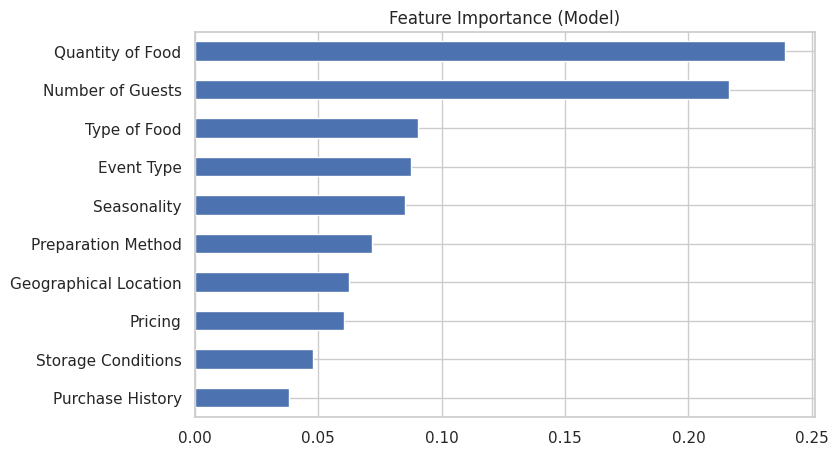

In [ ]:
# ---------------------------
# 6) Feature importance + Explainability (SHAP)
# ---------------------------
try:
    import shap
    explainer = shap.Explainer(best_model.predict, masker=feature_names) if hasattr(shap, "Explainer") else None
    # For tree models we can use TreeExplainer for better speed
    if hasattr(shap, "TreeExplainer"):
        try:
            expl = shap.TreeExplainer(best_model)
            shap_values = expl.shap_values(processed_df[feature_names])
            # Plot global importance
            shap.summary_plot(shap_values, processed_df[feature_names], show=True, plot_type="bar")
        except Exception as e:
            print("SHAP TreeExplainer failed:", e)
except Exception as e:
    print("SHAP not available or failed to run. Skipping SHAP plots. Error:", e)

# If shap not available, fallback to simple feature_importances_
if hasattr(best_model, "feature_importances_"):
    imp = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    imp.head(12).plot(kind="barh")
    plt.title("Feature Importance (Model)")
    plt.gca().invert_yaxis()
    plt.show()


SHAP TreeExplainer failed: "None of [Index(['Type of Food', 'Number of Guests', 'Event Type', 'Quantity of Food',\n       'Storage Conditions', 'Purchase History', 'Seasonality',\n       'Preparation Method', 'Geographical Location', 'Pricing'],\n      dtype='object')] are in the [columns]"


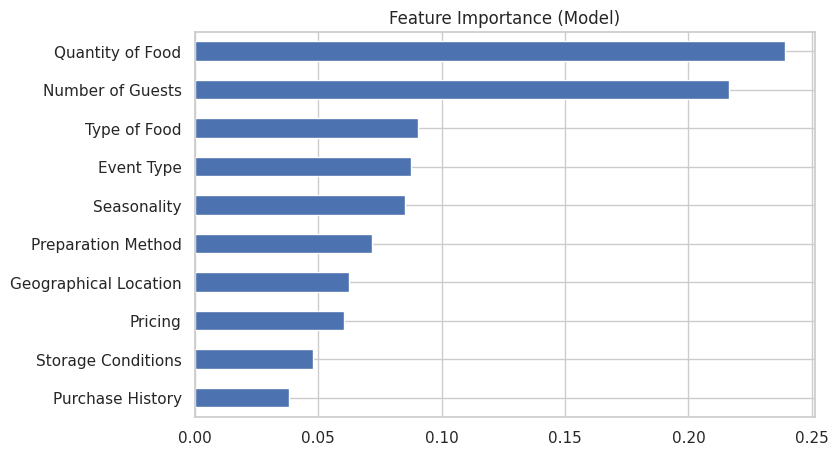

In [ ]:
# ---------------------------
# 6) Feature importance + Explainability (SHAP)
# ---------------------------
try:
    import shap
    explainer = shap.Explainer(best_model.predict, masker=feature_names) if hasattr(shap, "Explainer") else None
    # For tree models we can use TreeExplainer for better speed
    if hasattr(shap, "TreeExplainer"):
        try:
            expl = shap.TreeExplainer(best_model)
            shap_values = expl.shap_values(processed_df[feature_names])
            # Plot global importance
            shap.summary_plot(shap_values, processed_df[feature_names], show=True, plot_type="bar")
        except Exception as e:
            print("SHAP TreeExplainer failed:", e)
except Exception as e:
    print("SHAP not available or failed to run. Skipping SHAP plots. Error:", e)

# If shap not available, fallback to simple feature_importances_
if hasattr(best_model, "feature_importances_"):
    imp = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    imp.head(12).plot(kind="barh")
    plt.title("Feature Importance (Model)")
    plt.gca().invert_yaxis()
    plt.show()


Synthetic dataset saved to synthetic_food_wastage.csv (1000 rows).
Input DataFrame columns to train_and_compare_models: ['Date', 'Type of Food', 'Number of Guests', 'Event Type', 'Quantity of Food', 'Storage Conditions', 'Purchase History', 'Seasonality', 'Preparation Method', 'Geographical Location', 'Pricing', 'Wastage Food Amount']
Training RandomForest ...
RandomForest {'MAE': 5.74985, 'RMSE': 8.689148836336042, 'R2': -0.1715819107782115}
Training GradientBoosting ...
GradientBoosting {'MAE': 5.454088568953234, 'RMSE': 8.781605485347587, 'R2': -0.19664692702159248}
Training XGBoost ...
XGBoost {'MAE': 6.638312816619873, 'RMSE': 10.37858427709096, 'R2': -0.6714537143707275}

✅ Best model: RandomForest with metrics: {'MAE': 5.74985, 'RMSE': 8.689148836336042, 'R2': -0.1715819107782115}
✅ Best model, Scaler, Encoders, and Feature Names saved.

Model comparison summary:
RandomForest {'MAE': 5.74985, 'RMSE': 8.689148836336042, 'R2': -0.1715819107782115}
GradientBoosting {'MAE': 5.454088

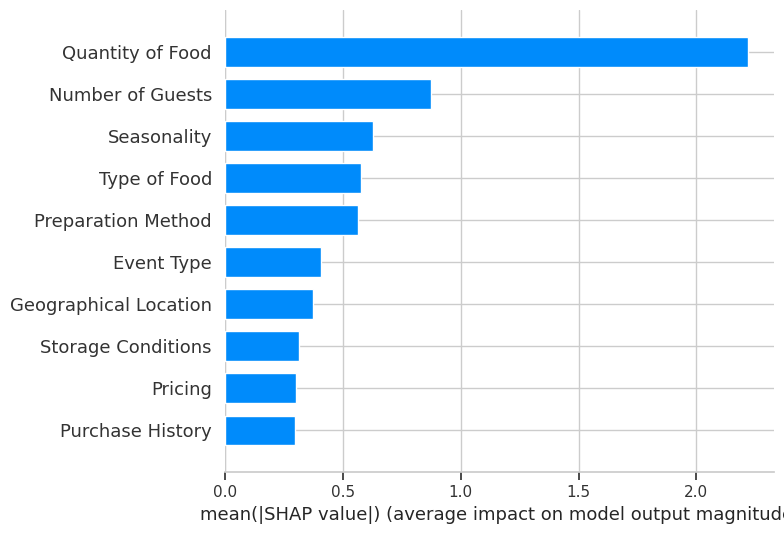

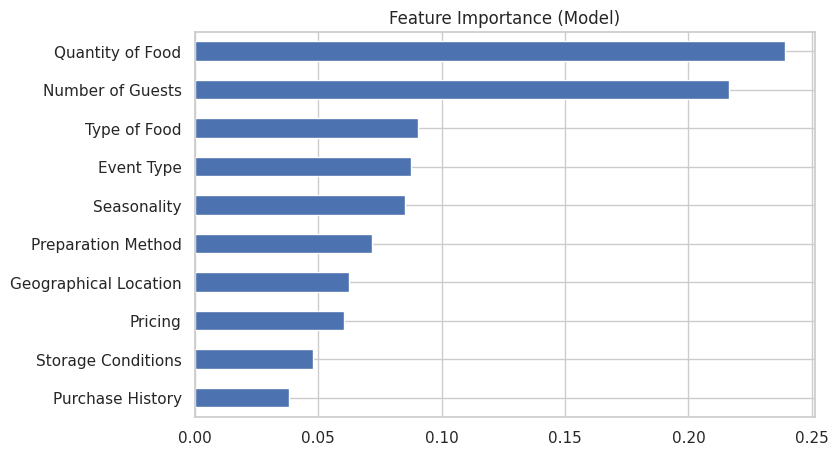

In [ ]:
# Ensure utility functions are defined and then run the training process

import pandas as pd
import numpy as np
import math
import os
import joblib
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Try importing XGBRegressor, but handle if not installed
try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None
    print("XGBoost not installed. Install with !pip install xgboost for XGBoost model.")

# Try importing SHAP, but handle if not installed
try:
    import shap
    # Suppress specific SHAP warnings if necessary
    shap.initjs() # For interactive plots in some environments
except ImportError:
    shap = None
    print("SHAP not installed. Install with !pip install shap for explainability plots.")
except Exception as e:
    shap = None
    print(f"SHAP available but failed to initialize: {e}. Skipping SHAP plots.")


# --- Redefine Utility Functions (to ensure availability) ---

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def safe_label_encode_df(df, cols):
    encs = {}
    for c in cols:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c].astype(str))
        encs[c] = le
    return df, encs

def inverse_transform_label(encoders, col, value):
    le = encoders.get(col)
    if le is None:
        return value
    try:
        return le.inverse_transform([int(value)])[0]
    except Exception:
        return value

def preprocess_df(df, training=True, label_encoders=None, scaler=None):
    df = df.copy()
    # Ensure some expected columns exist; fillna simple strategy
    expected_cats = [
        "Type of Food", "Event Type", "Storage Conditions", "Purchase History",
        "Seasonality", "Preparation Method", "Geographical Location", "Pricing"
    ]
    for c in expected_cats:
        if c not in df.columns:
            df[c] = "Unknown"

    # If Date missing, create synthetic Date (so EDA/time-series works)
    if "Date" not in df.columns:
        # create recent dates if training dataset without date
        df["Date"] = pd.date_range(end=pd.Timestamp.today(), periods=len(df)).to_series().reset_index(drop=True)

    # Convert Date to datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    # Fill numeric NA
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())

    # Encode categoricals with LabelEncoder
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    # we don't want to encode Date string - drop it temporarily
    if "Date" in cat_cols:
        cat_cols.remove("Date")

    if training:
        df, encs = safe_label_encode_df(df, cat_cols)
    else:
        encs = label_encoders or {}
        for c in cat_cols:
            if c in encs:
                le = encs[c]
                # unseen labels -> map to nearest (use try/except)
                df[c] = df[c].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
            else:
                # fallback numeric encoding by factorizing
                df[c] = pd.factorize(df[c].astype(str))[0]


    # Scale numeric features (except target and Date)
    feature_cols = [c for c in df.columns if c not in ["Wastage Food Amount", "Date"]]
    # Ensure all feature columns exist before scaling - add dummy if missing (shouldn't happen with synthetic)
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0.0 # Add missing column with default value

    if training:
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
        # Save feature names used during training
        df.feature_names_in_ = feature_cols # Store feature names in the DataFrame
    else:
        if scaler is not None:
            df[feature_cols] = scaler.transform(df[feature_cols])
        else:
            # no scaler provided -> do nothing
            pass


    return df, encs, scaler

def make_synthetic_dataset(n=1000, outpath="synthetic_food_wastage.csv", seed=42):
    np.random.seed(seed)
    types = ["Vegetables", "Meat", "Dairy", "Grains", "Sweets"]
    event_types = ["Corporate", "Birthday", "Wedding", "Religious", "Casual"]
    storage = ["Refrigerated", "Room Temperature"]
    purchase = ["Regular", "LastMinute"]
    seasonality = ["Summer", "Winter", "Monsoon", "All Seasons"]
    prep = ["Buffet", "Plated", "Finger Food"]
    locations = ["Urban", "Suburban", "Rural"]
    pricing = ["Low", "Moderate", "High"]

    rows = []
    start_date = datetime.today() - timedelta(days=n)
    for i in range(n):
        guests = int(np.clip(np.random.poisson(50), 5, 500))
        qty = int(np.clip(guests * (0.2 + np.random.rand()*0.8), 5, 2000))
        base_waste = max(0, int(qty * (0.05 + np.random.rand()*0.25)))
        # add noise for event type & storage conditions
        event = np.random.choice(event_types)
        if event == "Wedding":
            base_waste += int(0.05 * qty)
        if np.random.rand() < 0.1:
            base_waste += int(np.random.rand()*50)
        row = {
            "Date": (start_date + timedelta(days=i)).strftime("%Y-%m-%d"),
            "Type of Food": np.random.choice(types),
            "Number of Guests": guests,
            "Event Type": event,
            "Quantity of Food": qty,
            "Storage Conditions": np.random.choice(storage),
            "Purchase History": np.random.choice(purchase),
            "Seasonality": np.random.choice(seasonality),
            "Preparation Method": np.random.choice(prep),
            "Geographical Location": np.random.choice(locations),
            "Pricing": np.random.choice(pricing),
            "Wastage Food Amount": base_waste
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(outpath, index=False)
    print(f"Synthetic dataset saved to {outpath} ({n} rows).")
    return df

# Define paths for saving artifacts
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "wastage_best_model.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, "wastage_scaler.joblib")
LE_ENCODERS_PATH = os.path.join(MODEL_DIR, "wastage_label_encoders.joblib")
FEATURE_NAMES_PATH = os.path.join(MODEL_DIR, "wastage_feature_names.joblib") # Path to save feature names


# NGO database (simple)
NGOS = {
    "Urban": ["NGO FoodBank Delhi", "Robin Hood Army", "CityMeals"],
    "Suburban": ["Akshaya Patra", "Feeding India"],
    "Rural": ["Gram Seva Trust", "Village Relief NGO"]
}

# Smarter NGO allocation logic (re-defined for availability)
def suggest_ngo_allocation(location, predicted_waste):
    """
    Returns:
      - string message for small waste
      - dict of NGO -> allocated amount for larger waste
    Logic:
      - <20 kg -> no redistribution
      - 20-50 kg -> single NGO (closest), if multiple choose first
      - >50 kg -> split among available NGOs in location proportionally (equal split fallback)
    """
    try:
        predicted_waste = float(predicted_waste)
    except:
        return "Invalid waste value"

    if predicted_waste < 20:
        return "No redistribution needed (minimal waste)."

    ngos = NGOS.get(location, [])
    if not ngos:
        return "No NGO data available for this location."

    if predicted_waste <= 50:
        # allocate to single NGO (choose one with most capacity heuristic: pick first)
        return {ngos[0]: f"{predicted_waste:.2f} kg"}

    # For big waste -> split among NGOs; if very large, split into chunks of max 50kg each NGO
    num_ngos = len(ngos)
    base_split = predicted_waste / num_ngos
    allocation = {}
    for ngo in ngos:
        allocation[ngo] = f"{base_split:.2f} kg"
    return allocation

# --- Train Models ---

# Generate a synthetic food wastage dataset
synthetic_df = make_synthetic_dataset(n=1000)

# Preprocess the synthetic data
# Ensure preprocess_df and its dependencies (LabelEncoder, StandardScaler) are available
processed_synthetic_df, encoders, scaler = preprocess_df(synthetic_df, training=True)

# Train and compare models using the synthetic data
# Ensure train_and_compare_models and its dependencies (evaluate_model, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor) are available
def train_and_compare_models(df, target_col="Wastage Food Amount"):
    print(f"Input DataFrame columns to train_and_compare_models: {df.columns.tolist()}")
    # Ensure target exists
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in the DataFrame.")
        raise ValueError(f"Dataset must contain '{target_col}' column as target.")

    # features exclude Date and target
    X = df.drop(columns=[target_col, "Date"], errors='ignore')
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    }
    # Add XGBoost only if available
    if XGBRegressor:
         models["XGBoost"] = XGBRegressor(n_estimators=200, random_state=42, verbosity=0)


    results = {}
    for name, m in models.items():
        print(f"Training {name} ...")
        m.fit(X_train, y_train)
        preds = m.predict(X_test)
        res = evaluate_model(y_test, preds)
        results[name] = {"model": m, "metrics": res}
        print(name, res)

    # Choose best by RMSE (lower better)
    if results:
        best_name = min(results.keys(), key=lambda k: results[k]["metrics"]["RMSE"])
        best_model = results[best_name]["model"]
        print(f"\n✅ Best model: {best_name} with metrics:", results[best_name]["metrics"])

        # Save selected model
        joblib.dump(best_model, MODEL_PATH)
        joblib.dump(scaler, SCALER_PATH) # Also save scaler
        joblib.dump(encoders, LE_ENCODERS_PATH) # Also save encoders
        joblib.dump(X_train.columns.tolist(), FEATURE_NAMES_PATH) # Save feature names
        print("✅ Best model, Scaler, Encoders, and Feature Names saved.")

        return results, best_name, best_model, X_train.columns
    else:
        print("No models were trained.")
        return None, None, None, None


results, best_name, best_model, feature_names = train_and_compare_models(processed_synthetic_df)

# Pretty print comparison (Assuming results were returned)
if results:
    print("\nModel comparison summary:")
    for k,v in results.items():
        print(k, v["metrics"])

# ---------------------------
# 6) Feature importance + Explainability (SHAP) - Moved here to ensure variables are defined
# ---------------------------
# Check if best_model and feature_names are defined
if 'best_model' in locals() and 'feature_names' in locals():
    try:
        if shap is not None:
            explainer = shap.Explainer(best_model.predict, masker=processed_synthetic_df[feature_names]) if hasattr(shap, "Explainer") else None
            # For tree models we can use TreeExplainer for better speed
            if hasattr(shap, "TreeExplainer"):
                try:
                    expl = shap.TreeExplainer(best_model)
                    # Use X_train from train_and_compare_models for SHAP values if possible
                    # Otherwise, use processed_synthetic_df filtered by feature_names
                    # Assuming processed_synthetic_df and feature_names are available
                    shap_values = expl.shap_values(processed_synthetic_df[feature_names])
                    # Plot global importance
                    shap.summary_plot(shap_values, processed_synthetic_df[feature_names], show=True, plot_type="bar")
                except Exception as e:
                    print("SHAP TreeExplainer failed:", e)
        else:
            print("SHAP library not available. Skipping SHAP plots.")

    except Exception as e:
        print("SHAP plotting failed unexpectedly. Error:", e)

    # Fallback to simple feature_importances_ if SHAP fails or is not available
    if hasattr(best_model, "feature_importances_"):
        imp = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(8,5))
        imp.head(12).plot(kind="barh")
        plt.title("Feature Importance (Model)")
        plt.gca().invert_yaxis()
        plt.show()
else:
    print("Error: Model training did not complete successfully. 'best_model' or 'feature_names' not found.")

In [ ]:
# ---------------------------
# 7) NGO Suggestion Logic
# ---------------------------
def suggest_ngo_allocation(location, predicted_waste):
    # Input: location str (Urban/Suburban/Rural) and predicted_waste (numeric)
    try:
        predicted_waste = float(predicted_waste)
    except:
        return "Invalid predicted_waste"
    if predicted_waste < 10:
        return "No redistribution needed. Use composting / in-house consumption."
    ngos = NGOS.get(location, [])
    if not ngos:
        return "No NGO data available for this location."
    # Prioritize: if small, one NGO; if large, split among all
    if predicted_waste <= 50 and len(ngos) >= 1:
        return {ngos[0]: f"{predicted_waste:.2f} kg"}
    split = predicted_waste / len(ngos)
    return {ngo: f"{split:.2f} kg" for ngo in ngos}

# Quick local test
print(suggest_ngo_allocation("Urban", 8))
print(suggest_ngo_allocation("Urban", 120))

No redistribution needed. Use composting / in-house consumption.
{'NGO FoodBank Delhi': '40.00 kg', 'Robin Hood Army': '40.00 kg', 'CityMeals': '40.00 kg'}


In [42]:
# ---------------------------
# 8) Prediction helper for new samples (uses saved encoders/scaler/model)
# ---------------------------
def predict_new(input_df):
    # Load artifacts
    model = joblib.load(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    encs = joblib.load(LE_ENCODERS_PATH)
    feature_names_loaded = joblib.load(FEATURE_NAMES_PATH) # Load feature names

    df_new = input_df.copy()
    if "Wastage Food Amount" not in df_new.columns:
        df_new["Wastage Food Amount"] = 0

    # Date features - ensure they are created if Date column exists
    if "Date" in df_new.columns:
        df_new["Date"] = pd.to_datetime(df_new["Date"], errors="coerce")
        # Add DayOfWeek and Month if they don't exist
        if "DayOfWeek" not in df_new.columns:
            df_new["DayOfWeek"] = df_new["Date"].dt.dayofweek
        if "Month" not in df_new.columns:
            df_new["Month"] = df_new["Date"].dt.month
    else:
         # Add placeholder columns if Date is missing in new data
         if "DayOfWeek" not in df_new.columns:
             df_new["DayOfWeek"] = -1 # Or other appropriate placeholder
         if "Month" not in df_new.columns:
             df_new["Month"] = -1 # Or other appropriate placeholder


    # Encode categorical columns using saved LabelEncoders (unseen -> -1)
    cat_cols_to_encode = [c for c in df_new.select_dtypes(include=["object"]).columns if c != "Date"] # Exclude Date string
    for c in cat_cols_to_encode:
        df_new[c] = df_new[c].astype(str)
        if c in encs:
            le = encs[c]
            # Use .apply with lambda for transformation and handling unseen
            df_new[c] = df_new[c].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        else:
            # If no encoder saved for this column, create a default numeric column
            df_new[c] = 0


    # Align columns with training features - CRITICAL STEP
    # Create a new DataFrame with columns in the order of feature_names_loaded
    aligned_df = pd.DataFrame(columns=feature_names_loaded)

    # Copy data from df_new to aligned_df, matching columns
    for col in feature_names_loaded:
        if col in df_new.columns:
            aligned_df[col] = df_new[col]
        else:
            # If a feature column is missing in the input data, fill with a default (e.g., 0 or median from training data if available)
            # For simplicity here, use 0. More robust would be to use median/mean from training data.
            aligned_df[col] = 0.0

    # Ensure the order is exactly as in training
    aligned_df = aligned_df[feature_names_loaded]


    # Scale features
    # Use the aligned_df for scaling and prediction
    X = aligned_df
    preds = model.predict(X)

    # Build results including NGO suggestion
    results = []
    # Need to iterate through the original input_df for location
    for i, row in input_df.iterrows():
        loc = row.get("Geographical Location", "Unknown")
        # Get the prediction corresponding to this original row's index
        # Assuming predict() maintains original index order, which it should for DataFrame input
        pred = float(preds[input_df.index.get_loc(i)]) if hasattr(preds, "__len__") else float(preds)

        suggestion = suggest_ngo_allocation(loc, pred)
        results.append({
            "Original Index": i, # Add original index for clarity
            "Predicted Waste (kg)": round(pred, 2),
            "Location": loc,
            "NGO Suggestion": suggestion
        })
    return results

# Example quick prediction
# Use synthetic data sample for a relevant example
sample = synthetic_df.sample(3).reset_index(drop=True) # Use synthetic_df
sample_display = sample.copy()
display(sample_display)
print("Predictions:", predict_new(sample_display))

,Date,Type of Food,Number of Guests,Event Type,Quantity of Food,Storage Conditions,Purchase History,Seasonality,Preparation Method,Geographical Location,Pricing,Wastage Food Amount
0,2023-10-05,Sweets,44,Corporate,37,Refrigerated,Regular,Monsoon,Plated,Urban,Moderate,6
1,2025-07-14,Sweets,51,Casual,50,Refrigerated,LastMinute,Monsoon,Plated,Suburban,Low,11
2,2025-05-16,Dairy,63,Corporate,57,Refrigerated,LastMinute,All Seasons,Finger Food,Rural,Moderate,8


Predictions: [{'Original Index': 0, 'Predicted Waste (kg)': 23.54, 'Location': np.str_('Urban'), 'NGO Suggestion': {'NGO FoodBank Delhi': '23.54 kg'}}, {'Original Index': 1, 'Predicted Waste (kg)': 23.39, 'Location': np.str_('Suburban'), 'NGO Suggestion': {'Akshaya Patra': '23.39 kg'}}, {'Original Index': 2, 'Predicted Waste (kg)': 20.0, 'Location': np.str_('Rural'), 'NGO Suggestion': {'Gram Seva Trust': '20.00 kg'}}]


In [41]:
# 9) Gradio Demo App
# Define UI fields (use representative defaults)
def predict_ui(
    date, food_type, number_of_guests, event_type, quantity_of_food,
    storage_conditions, purchase_history, seasonality, preparation_method,
    geographical_location, pricing
):
    row = pd.DataFrame([{
        "Date": date,
        "Type of Food": food_type,
        "Number of Guests": int(number_of_guests),
        "Event Type": event_type,
        "Quantity of Food": int(quantity_of_food),
        "Storage Conditions": storage_conditions,
        "Purchase History": purchase_history,
        "Seasonality": seasonality,
        "Preparation Method": preparation_method,
        "Geographical Location": geographical_location,
        "Pricing": pricing
    }])
    out = predict_new(row)[0]
    # Present nicely
    suggestion = out["NGO Suggestion"]
    if isinstance(suggestion, dict):
        suggestion_text = "\n".join([f"{k}: {v}" for k,v in suggestion.items()])
    else:
        suggestion_text = suggestion
    return f"Predicted Waste: {out['Predicted Waste (kg)']} kg\nLocation: {out['Location']}\nNGO Suggestion:\n{suggestion_text}"

# Build Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Food Wastage Prediction & Redistribution Demo")
    with gr.Row():
        with gr.Column():
            date = gr.Textbox(type='text', label="Date (YYYY-MM-DD)", value=datetime.today().strftime("%Y-%m-%d")) # Changed type to 'text' and updated label
            food_type = gr.Dropdown(["Vegetables","Meat","Dairy","Grains","Sweets"], label="Type of Food", value="Vegetables")
            number_of_guests = gr.Number(label="Number of Guests", value=50)
            event_type = gr.Dropdown(["Corporate","Birthday","Wedding","Religious","Casual"], label="Event Type", value="Casual")
            quantity_of_food = gr.Number(label="Quantity of Food (approx servings)", value=200)
            storage_conditions = gr.Dropdown(["Refrigerated","Room Temperature"], label="Storage Conditions", value="Room Temperature")
        with gr.Column():
            purchase_history = gr.Dropdown(["Regular","LastMinute"], label="Purchase History", value="Regular")
            seasonality = gr.Dropdown(["Summer","Winter","Monsoon","All Seasons"], label="Seasonality", value="All Seasons")
            preparation_method = gr.Dropdown(["Buffet","Plated","Finger Food"], label="Preparation Method", value="Buffet")
            geographical_location = gr.Dropdown(["Urban","Suburban","Rural"], label="Geographical Location", value="Urban")
            pricing = gr.Dropdown(["Low","Moderate","High"], label="Pricing", value="Moderate")

    output = gr.Textbox(label="Prediction & Redistribution Suggestion")
    btn = gr.Button("Predict & Suggest")
    btn.click(
        predict_ui,
        inputs=[date, food_type, number_of_guests, event_type, quantity_of_food,
                storage_conditions, purchase_history, seasonality, preparation_method,
                geographical_location, pricing],
        outputs=output
    )

# Launch the app (local)
print("🔹 Launching Gradio demo (local).")
demo.launch(share=False, inbrowser=False)

🔹 Launching Gradio demo (local).
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>